In an earlier [post](https://madhatter106.github.io/DataScienceCorner/posts/xarray-geoviews-a-new-perspective-on-oceanographic-data-part-i/) I briefly described the use of the xarray module to easily manipulate medium sized datasets.  I [then went on](https://madhatter106.github.io/DataScienceCorner/posts/xarray-geoviews-a-new-perspective-on-oceanographic-data-part-ii/) to describe a more complex though not necessarily more complicated example of aggregating data from multiple netCDF files and reshaping them as input to easily build an intuitive graphical output. Now for the fun part of building some nice visualization.

The data in question happens to be geophysical, 4-daily mapped *remote sensing reflectance uncertainty* for a number of spectra bands, loosely ranging from blue to red. At least in my experience, visualizing these data for public consumption can be cumbersome, requiring some significant, and therefore error-prone, coding. Typically, this means a lot of back-and-forth until a useful but also presentable format is achieved. For a different experience, I opted to give [GeoViews](http://geo.holoviews.org/) a try. GeoViews is designed to allow rapid creation of compelling visualizations with very few lines of code. This is quite in contrast with my experience with, e.g., [Matplotlib's Basemap toolkit](http://matplotlib.org/basemap/). Note that there are a few dependencies to install, so check the documentation if you wish to follow along.

GeoViews sits on top of [HoloViews](http://holoviews.org/), a library where the user is directed to annotate his or her data. Holoviews then takes the annotated data to render it with minimum fuss. 

>A quick note on the data: the data I  use here in this post is from my own work on remote sensing uncertainty, and not currently publicly available.
>However, this data has the same format as *SMI* (level-3, mapped) data that can be readily downloaded from the Ocean Color Processing Group's  [level-3 browser](https://oceancolor.gsfc.nasa.gov/cgi/l3). The methodology laid out in this post should therefore be directly applicable to any SMI data you care to download.

So without further ado, I'll jump right in!

---


Let's begin first with the necessary imports:

In [2]:
import warnings
warnings.filterwarnings("ignore")
import holoviews as hv
import geoviews as gv
from geoviews import feature as gf
from cartopy import crs
import numpy as np
import xarray as xr
from matplotlib import rcParams
import cmocean as cm
import seaborn
import os
import glob

Jupyter notebook by default restricts the size of embedded figures. I don't like that so to change that for some layout freedom:

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

Finally, I would like some uniformity in text layout across this notebook's graphic output - although for greater flexibility, I'll explore ways of customizing text in some parts of the graphic output.

In [4]:
rcParams['axes.formatter.limits']=[-2,3] # switch to engineering unit format beyond a certain range of numbers
rcParams['font.size'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 16

Holoviews features matplotlib and bokeh support, among others. For my purpose, the matplotlib backend is sufficient

In [5]:
hv.notebook_extension('matplotlib')

Next, defining some paths to the data produced in the previous [post](https://madhatter106.github.io/DataScienceCorner/posts/xarray-geoviews-a-new-perspective-on-oceanographic-data-part-ii/), and have a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) return them when needed.

In [6]:
dataDir = '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis'
origName = 'S20031932003196.L3m_4D*.nc'
fGen = glob.iglob(os.path.join(dataDir,origName))

Reminder: in the [last post](https://madhatter106.github.io/DataScienceCorner/posts/xarray-geoviews-a-new-perspective-on-oceanographic-data-part-ii/), I merged Rrs arrays creating in addition to the already existing lat/lon dimensions a third dimension, 'experiment, which indexed all five experiments conducted in this study, at a given band. The names of the new files now feature the spectral band that corresponds to the data they contain. I'm going to quickly organize the file paths into a dictionary with bands as keys so I can easily pass relevant file paths to xarray, and also so it's easy to see what I'm doing. Just so...

In [8]:
fileDict={file.rsplit('_',1)[1].strip('.nc'): file for file in fGen}
fileDict

{'412': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003196.L3m_4D_412.nc',
 '443': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003196.L3m_4D_443.nc',
 '490': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003196.L3m_4D_490.nc',
 '510': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003196.L3m_4D_510.nc',
 '555': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003196.L3m_4D_555.nc',
 '670': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003196.L3m_4D_670.nc'}

The next thing is to identify the relevant key dimensions (kdims) and value dimensions (vdims), which are inputs description semantics that HoloViews (and GeoViews) use to compose graphical output. The key dimensions, ***kdims*** determine how data can be indexed and therefore selected. ***vdims*** is the data that will be plotted. Given the datasets above all share the same dimension, this is pretty short.

In [9]:
kdims = ['lat', 'lon', 'experiment']
vdims = ['rrs_unc']

I'll load the first file, corresponding to the blue wavelength, 412nm.

In [10]:
rrsUncEnsemble412 = xr.open_dataset(fileDict['412'])

Quick look at the dataset to get my bearings:

In [11]:
rrsUncEnsemble412

<xarray.Dataset>
Dimensions:     (experiment: 5, lat: 1556, lon: 4318)
Coordinates:
  * lat         (lat) float64 81.17 81.08 81.0 80.92 80.83 80.75 80.67 80.58 ...
  * lon         (lon) float64 -179.9 -179.8 -179.7 -179.7 -179.6 -179.5 ...
  * experiment  (experiment) object 'Lt' 'AllAnc_Lt' 'Pressure' 'RH' 'WindSpeed'
Data variables:
    rrs_unc     (experiment, lat, lon) float64 nan nan nan nan nan nan nan ...

So rrs_unc is an array with dimensions a 5x1556x4318 array If this turns out be too much data, we could subsample by $\frac{1}{2}$ along the *lat* dimension, and $\frac{1}{5}$  along the *lon* dimension like so:

In [12]:
rrsUnc412 = rrsUncEnsemble412.data_vars['rrs_unc']

In [13]:
rrsUnc412Sub = rrsUnc412[:, ::2, ::5].copy()

Geoviews expects a dataset however...

In [14]:
rrsUnc412SubSet = rrsUnc412Sub.to_dataset()
rrsUncEnsemble412.close()

Next is to explain to GeoViews how to organize the visualization (via kdims and vdims) what projection to use (here I'll use the [plate carrée projection](https://en.wikipedia.org/wiki/Equirectangular_projection)). This will result in a gv.Dataset object wrapping the xarray dataset.

In [15]:
gvDataset = gv.Dataset(rrsUnc412SubSet, crs=crs.PlateCarree(),
                       kdims=kdims, vdims=vdims, group='Rrs uncertainty (412nm)')

Next is to create a collection of images indexed by lon/lat by building a HoloViews HoloMap; basically a fancy dictionary of gv.Image elements. The important point here is that I only specify two of the key dimensions; *lat* and *lon*. Let's see what happens to the third 'implied' dimension, *experiment*. The '\*'  specifies an overlay, in contrast to a '+' that would create a second frame in the layout. I'll demonstrate the latter further below

The next line specifies [options](http://holoviews.org/Tutorials/Options.html) for the Image object. Of potential interest to geoscientists is the use of one of the [cmocean](http://matplotlib.org/cmocean/) colormaps, which are adjusted for uniform luminance to avoid [unintended overemphasis of random features](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/). 

In [37]:
%opts Image {+axiswise} [colorbar=True, logz=True] style(cmap=cm.cm.thermal ) Overlay [fig_size=800]
%opts Spread [aspect=2, fig_size=300]

b':HoloMap   [experiment]\n   :Overlay\n      .Rrs_uncertainty_left_parenthesis_412nm_right_parenthesis.I :Image   [lon,lat]   (rrs_unc)\n      .Land.I                                                     :Feature   [Longitude,Latitude]'
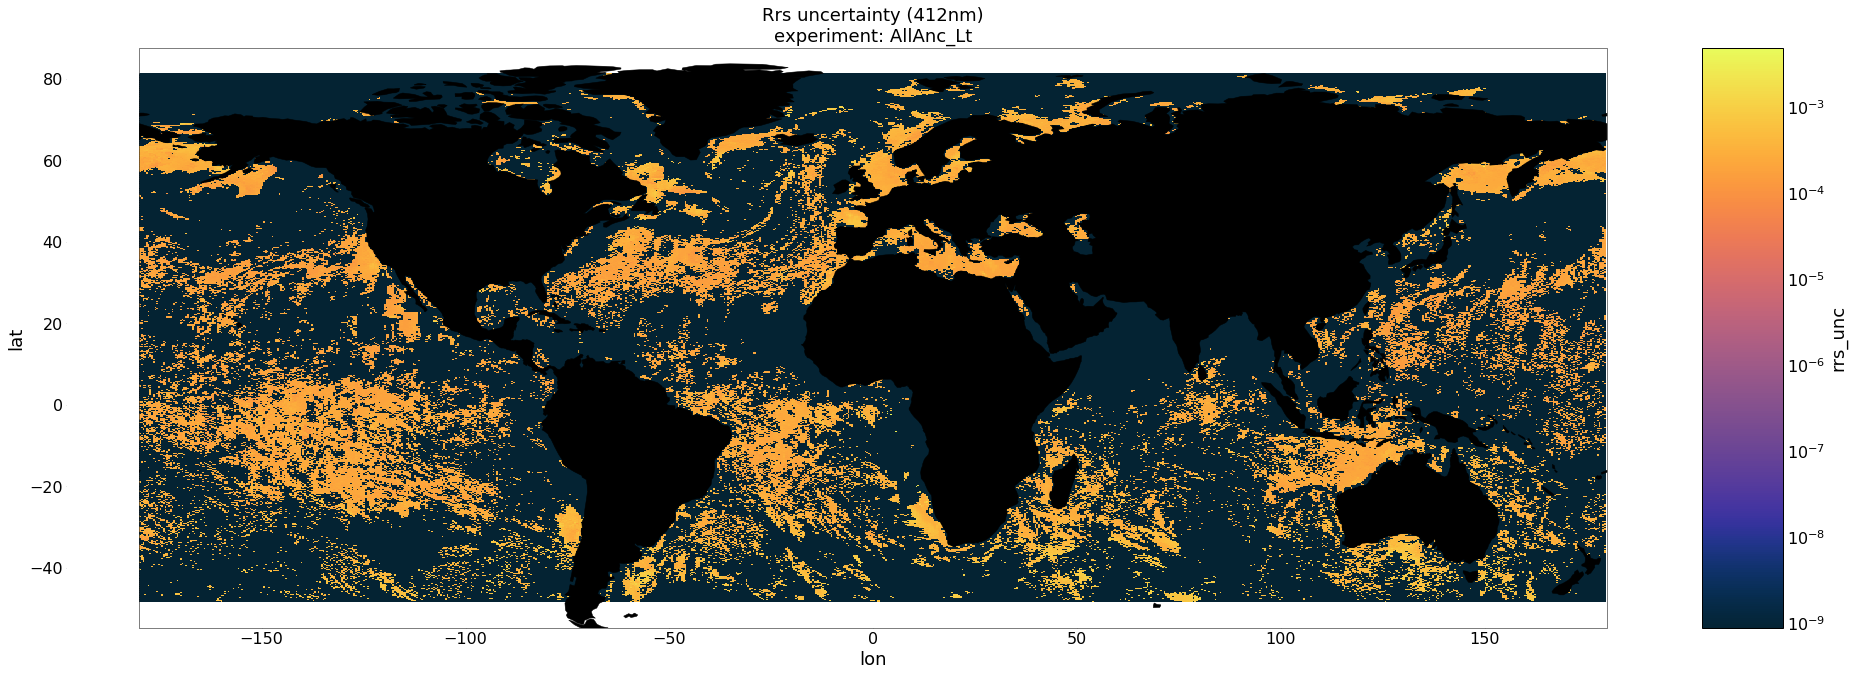
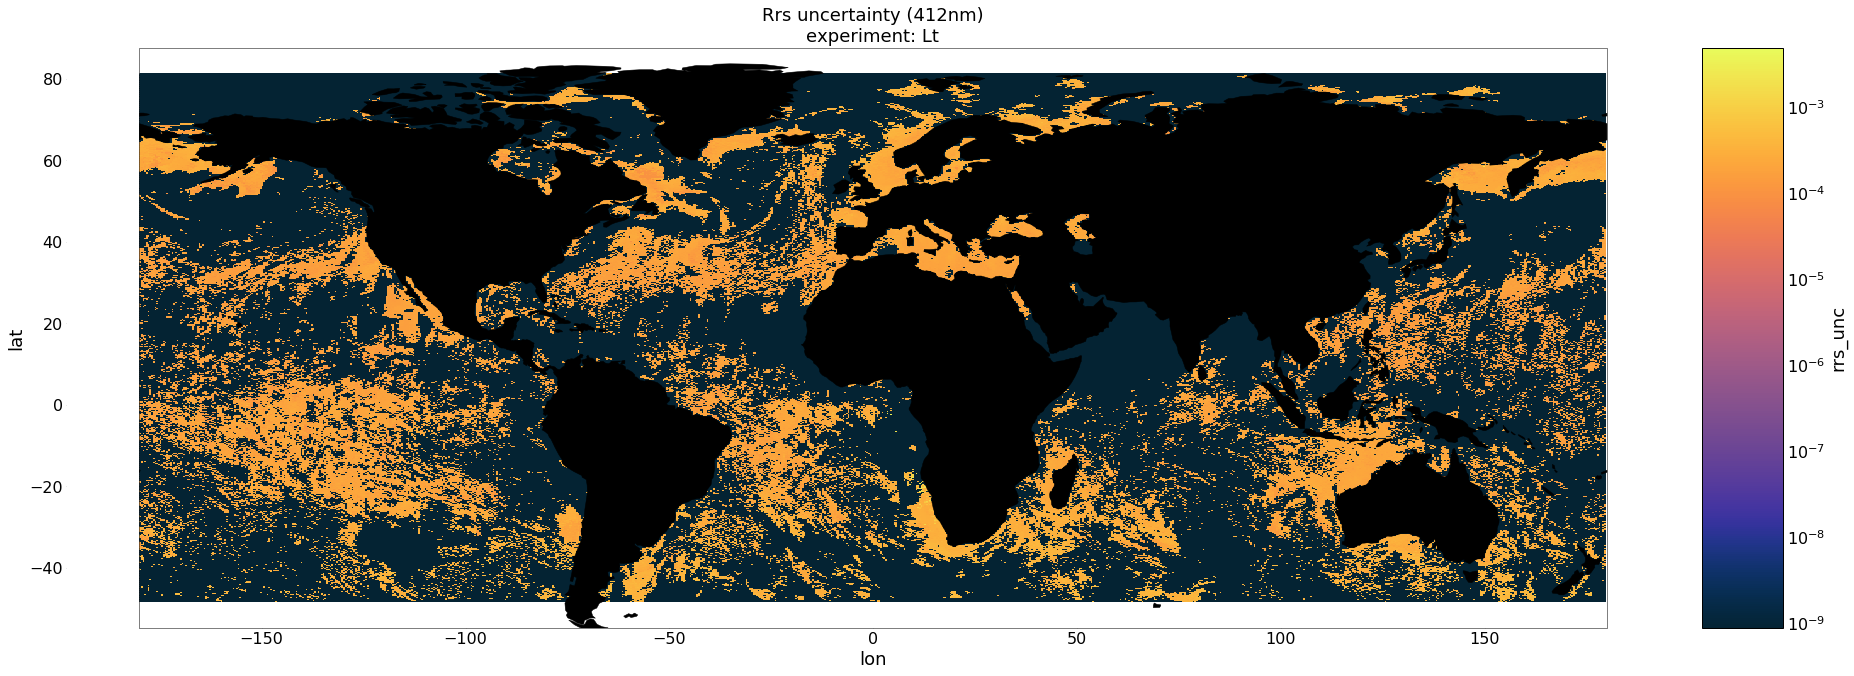
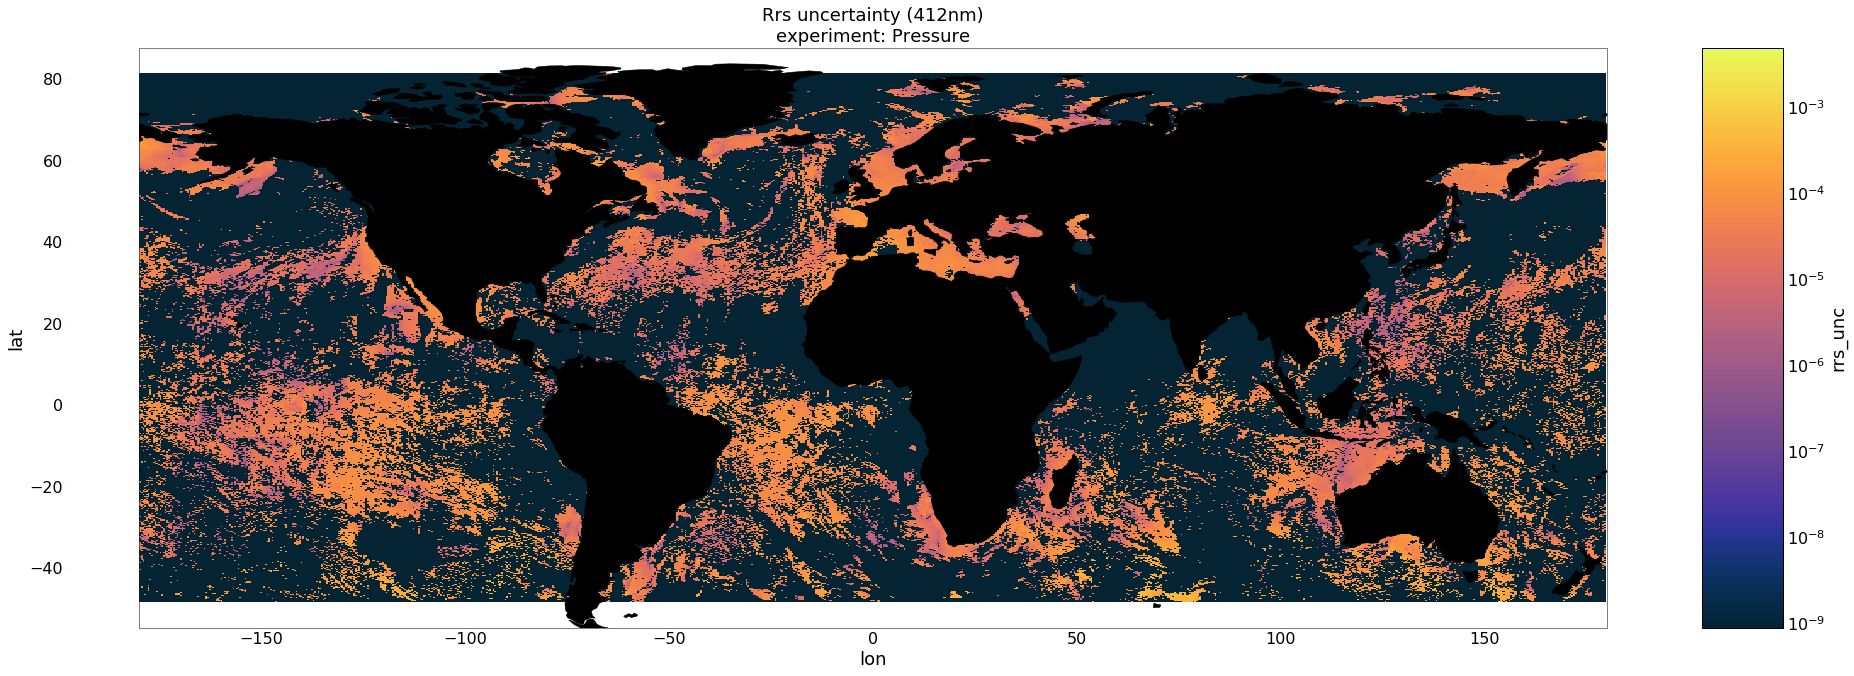
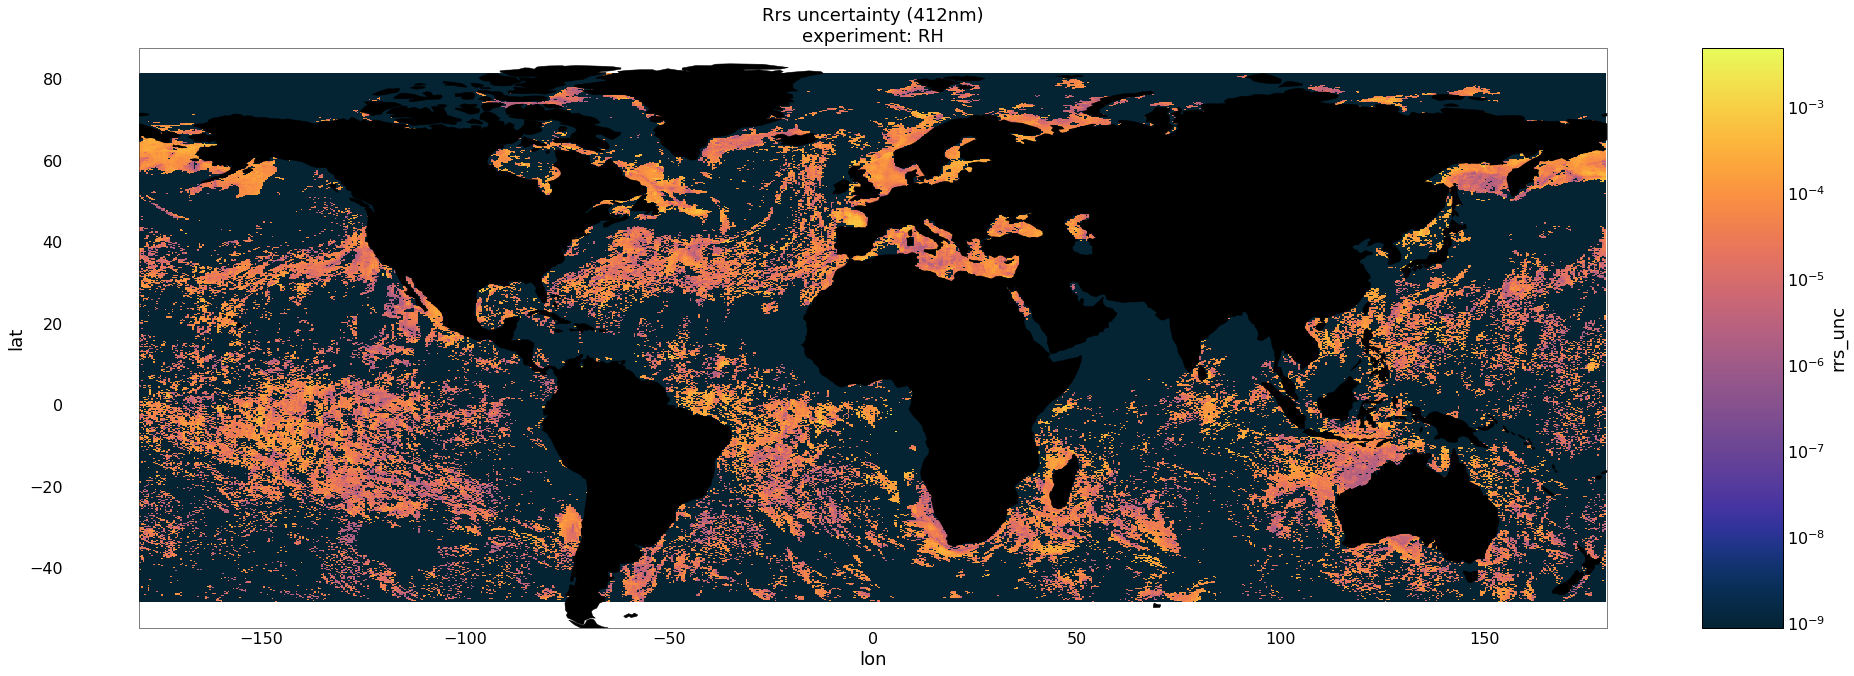
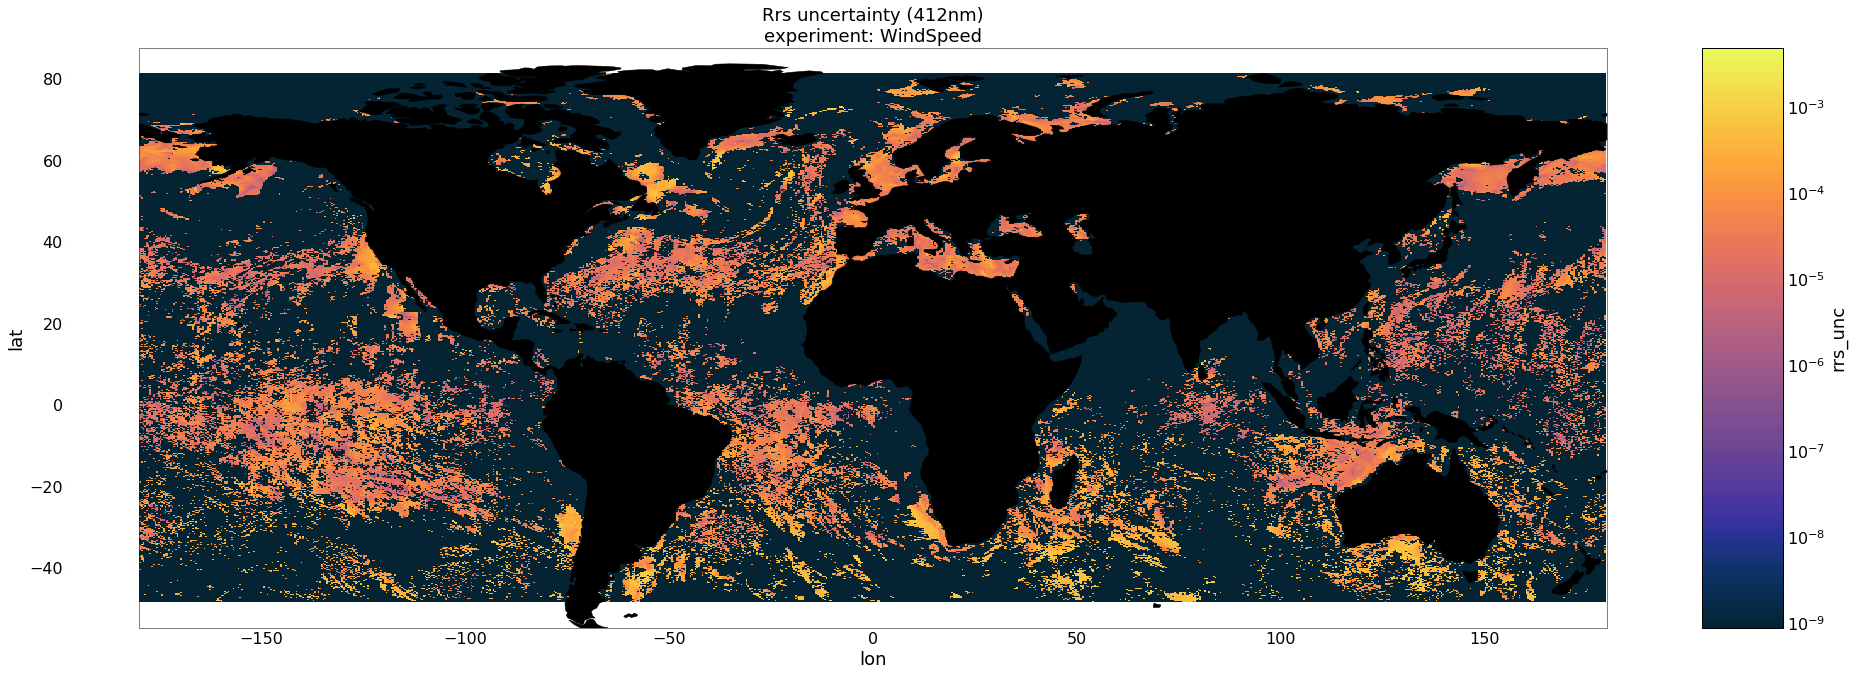

In [32]:
rrs_unc_hdl = gvDataset.to(gv.Image, ['lon', 'lat']) * gf.land(style=dict(facecolor='black'))
rrs_unc_hdl

OK, but the range is off; in particular the darker colors are underutilized. I'm going to specify a max (and min) range to achieve normalization across the frames thus making them comparable.

In [17]:
rrs_unc_hdl2 =gvDataset.redim(rrs_unc=dict(range=(2e-7,2e-3))).to(gv.Image,['lon','lat'],
                                                                  ['rrs_unc'])* gf.land(style=dict(facecolor='gray'))

b':NdLayout   [experiment]\n   :Overlay\n      .Rrs_uncertainty_left_parenthesis_412nm_right_parenthesis.I :Image   [lon,lat]   (rrs_unc)\n      .Land.I                                                     :Feature   [Longitude,Latitude]'
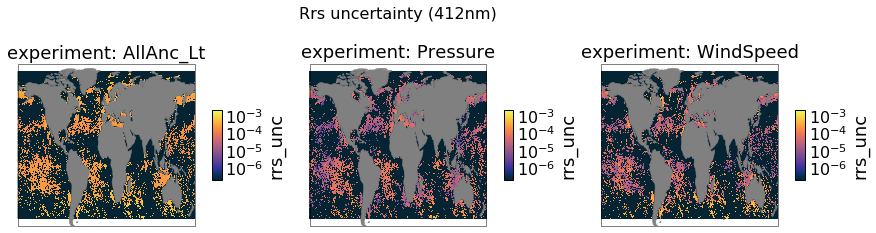

In [57]:
%%opts Overlay [aspect=1.2]
rrs_unc_hdl2[::2].layout()